We have solved a simplified version of this problem already, using a different method, here: 
https://grainofsandendlessbeach.blogspot.com/2024/08/polygon-obstacle-path-finder-chapter-3.html

Previously (link above) we created a graph by finding all vertices visible from a particular vertex, for all vertices. Once the graph was fully formed, we ran a few graph search algorithms on it to find a path from the start to the end. Obviously A-star and uniform-cost search (dijkstra) found the shortest path (the red and green lines). Here we are taking a different approach: We are asked in Exercise 4.11 to turn this problem into an environment problem. No longer do we form a graph by fully surveying the problem then running an algorithm on the graph to obtain a solution. This time we are asked to provide an agent with percepts in the form of a collection of visible vertices. The agent then makes a decision on what action to take: this comes in the form of a vector describing a straight-line path to follow.

One of the difficulties in this version of the problem is that we have to take into account the size of the agent. For simplicity I am going to assume that the agent is circular. If this was not the case then it is a decent assumption to assume that the agent is bounded by a circular region. In the original problem (3.7, linked above) the agent was a point mass so we did not have to make a distinction between visbility and reachability. This time we are searching for collision between a disk and an obstacle, during the execution of an action. This is commonly referred to as swept collision detection.

If you want to run this code, look for `polygon_env.ipynb`, here: 
https://github.com/hmp-anthony/AIMA

## My Idea!



In [66]:
from search_2 import *
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from agents import *

class vertex:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __repr__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"
        
    def __add__(self, other):
        return vertex(self.x + other.x, self.y + other.y)

    def __sub__(self, other):
        return vertex(self.x - other.x, self.y - other.y)

    def __mul__(self, other):
        if(isinstance(other, vertex)):
            return self.x * other.x + self.y * other.y
        if(isinstance(other, float) or isinstance(other, int)):
            return vertex(self.x * other, self.y * other)

    def __eq__(self, other):
        if(isinstance(other, vertex)):
            return self.x == other.x and self.y == other.y
        return False

    __rmul__ = __mul__

    def cross(self, other):
        return self.x * other.y - self.y * other.x

class polygon:
    # vertices are passed in the order they appear if
    # you were to walk around the vertices.
    def __init__(self, vertices):
        self.vertices = vertices

    def get_vertices(self):
        return self.vertices

    def intersect(self, begin, end):
        vs = self.vertices
        p = begin
        r = end - begin
        for i in range(len(vs)):
            q = vs[i]
            if i < len(vs) - 1:
                s = vs[i+1] - vs[i]
            else:
                s = vs[0] - vs[i]
            rxs = r.cross(s)
            qmp = q - p
            # if r and s are parallel
            if 0 <= rxs < 0.0001:
                # collinear and trivially intersecting
                if(abs(qmp.cross(s)) < 0.0001 or abs(qmp.cross(r)) < 0.0001):
                    return True
                # parallel and not intersecting
                return False
            u = qmp.cross(r) / rxs
            t = qmp.cross(s) / rxs
            if 0 < u < 1 and 0 < t < 1:
                return True
        return False

class PolygonAgent(Agent):
    def __init__(self, program = None):
        super().__init__(program)
        # a pair of vertices, [vertex(n1, n2), vertex(x0, y0)], where
        # (n1, n2) is a normal and (x0, y0) is a point on the line.
        self.visibility_plane = None
        self.size = 0.5

# program takes percepts and spits out actions
def program(percept):
    # we take in a vector of vertices
    if len(percept) > 0:
        return random.choice(percept)

class Environment:
    def __init__(self, polygons, agent, initial_position):
        self.agent = agent
        self.agent_position = initial_position
        self.polygons = polygons

    def percept(self):
        # We need to find all visible vertices.
        vertices = []
        for p in self.polygons:
            vertices.extend(p.get_vertices())
        visible_vertices = []
        for v in vertices:
            visible = True
            if self.agent.visibility_plane:
                n = self.agent.visibility_plane[0]
                x = self.agent.visibility_plane[1]
                # the vertex is on the wrong side of the vis-plane
                if (v - x) * n < 0:
                    continue
            # the line segment from agent to vertex
            for p in self.polygons:
                if p.intersect(self.agent_position, v):
                    visible = False
                    break
            if(visible):
                visible_vertices.append(v)
        return visible_vertices

    def execute_action(self, action):
        if isinstance(action, vertex):
            self.move_agent(action)

    def move_agent(self, location):
        v = self.agent_position
        w = location - self.agent_position
        r = agent.size
        t = 0
        for t in range(1000):
            center = v + t * w
            for p in self.polygons:
                vs = p.vertices
                for i in range(len(vs)):
                    s = vs[i]
                    if i < len(vs) - 1:
                        e = vs[i+1] - vs[i]
                    else:
                        e = vs[0] - vs[i]
                    a = s.x - center.x
                    b = e.x
                    c = s.y - center.y
                    d = e.y
                    A = b*b + d*d
                    B = 2*(a*b + c*d)
                    C = a*a + c*c - r*r
                    D = B*B - 4*A*C
                    if(D >= 0):
                        z1 = (-B + math.sqrt(D))/(2 * A)
                        z2 = (-B - math.sqrt(D))/(2 * A)
                        print(D,z1,z2)
                        break
            t += 0.001
        print(location)
    
    def step(self):
        action = agent.program(self.percept())
        self.execute_action(action)

    def run(self, steps=1):
        for step in range(steps): 
            self.step()

4.0 1.25 0.75
4.0 -6.75 -7.25
9.0 11.166666666666666 10.833333333333334
(8, 2)


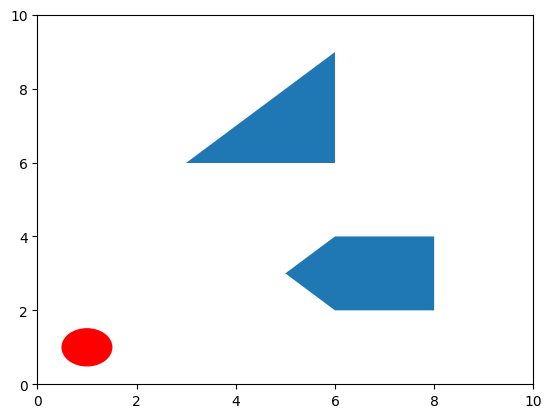

In [67]:
polygons = [polygon([vertex(6,2), vertex(8,2), vertex(8,4), vertex(6,4), vertex(5,3)]),
            polygon([vertex(3,6), vertex(6,6), vertex(6,9)])]

initial_position = vertex(1,1)
goal = vertex(8,8)

agent = PolygonAgent(program)
env = Environment(polygons, agent, initial_position)
env.run()

polygon_data = []
for p in polygons:
    vertex_list = p.get_vertices()
    vertex_list = [(v.x, v.y) for v in vertex_list]
    plot_p = Polygon(vertex_list)
    polygon_data.append(plot_p)

fig,ax = plt.subplots()

for p in polygon_data:
    ax.add_patch(p)

circle1 = plt.Circle((env.agent_position.x, env.agent_position.y), agent.size, color='r')
plt.gca().add_patch(circle1)

ax.set_xlim([0,10])
ax.set_ylim([0,10])
plt.show()
